# CSE 6240 - Web Search & Text Mining - Homework 3

In [1]:
# __author__ = 'Bhanu Verma'
# GTid = '903151012'

In [168]:
import csv
import pprint
import math
import numpy as np
from scipy.optimize import fmin_bfgs
import matplotlib.pyplot as plt
import _thread
import threading
import time
%matplotlib inline

In [3]:
def read_data(path, linear):
    degree = 8
    x = []
    y = []
    x_n = []
    with open(path, 'r') as datafile:
        file_reader = csv.reader(datafile, delimiter=',')
        
        for row in file_reader:
            x_1 = float(row[0])
            x_2 = float(row[1])
            x.append((x_1,x_2))
            if (not linear):
                temp = []
                for i in range(1, degree+1):
                    for j in range(0,i+1):
                        val = (x_1**(i-j)) * ((x_2)**j)
                        temp.append(float(val))
                x_n.append(temp)
            y.append(int(row[2]))
            
    if (linear):
        return x, y
    else:
        return x, x_n ,y

In [4]:
def get_sigmoid(theta, train_x):
    theta = np.reshape(theta,(len(theta),1))        # convert it to a column vector first
    z = np.dot(train_x,theta)                       # do matrix multiplication of the vectors
    den = 1.0 + math.e ** (-1.0 * z)                # calculate the denominator for the sigmoid
    sigmoid_val = 1.0/den
    
    return sigmoid_val

In [5]:
def get_h_theta(theta, train_x):
    h_theta_val = get_sigmoid(theta, train_x)
    
    return h_theta_val

In [6]:
def cost_function(theta, train_x, train_y, lambda_val = 0.0):
    training_size = float(train_x.shape[0])
    
    term_a = (1.0 * train_y) * np.log(get_h_theta(theta, train_x))
    term_b = (1.0 - train_y) * np.log(1.0 - get_h_theta(theta, train_x))
    cost = -(term_a + term_b)
    cost += (float(lambda_val) / (2.0 * training_size)) * np.sum(theta[1:]**2)
    
    for i in range(cost.size):
        if np.isnan(cost[i][0]):
            cost[i][0] = 0
        elif (cost[i][0] == np.inf):
            cost[i][0] = 10000
    
    cost = np.sum(cost) / training_size
    
    return cost

In [7]:
def gradient_function(theta, train_x, train_y, lambda_val=1.0):
    training_size = float(train_x.shape[0])
    delta_val = np.sum((get_h_theta(theta, train_x) - train_y) * train_x, axis=0)
    grad = (1.0 / training_size) * delta_val
    grad[1:] += (float(lambda_val) / training_size) * theta[1:]
    
    return grad

In [8]:
def run_optimization(train_x, train_y, lambda_val):
    training_size, dim_size = train_x.shape
    train_X = np.concatenate((np.ones((training_size, 1), dtype=float), train_x), axis=1)
    train_Y = train_y.reshape((training_size, 1))
    dim_size += 1                  # adjusting for theta zero
    theta = np.random.rand(dim_size, 1)
    optimized_theta = fmin_bfgs(cost_function, theta, fprime=gradient_function, args=(train_X,train_Y,lambda_val))
    
    return optimized_theta

In [9]:
def draw_scatter_plot(pos_data, neg_data, plotLabel, x_axis_label, y_axis_label,fig_no):
    plt.figure(fig_no, figsize=(10, 7))

    plt.subplot(1,1,1)
    plt.title(plotLabel)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)

    admit_axis_x = pos_data[:,[0]]
    admit_axis_y = pos_data[:,[1]]
    pos = plt.scatter(admit_axis_x, admit_axis_y, s=50, marker='+', color='green', alpha=0.8)

    reject_axis_x = neg_data[:,[0]]
    reject_axis_y = neg_data[:,[1]]
    neg = plt.scatter(reject_axis_x, reject_axis_y,s=50, marker='o', color='red', alpha=0.8)
    plt.legend((pos, neg),('Accepted', 'Not Accepted'),scatterpoints=1,loc='upper right',ncol=3,fontsize=12)
    plt.grid(True)
    plt.show()

In [10]:
def plot_decision_boundary(linear,pos_data, neg_data, plotLabel, x_axis_label, y_axis_label,fig_no,x_points,y_points,z):
    plt.figure(fig_no, figsize=(10, 7))

    plt.subplot(1,1,1)
    plt.title(plotLabel)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)

    admit_axis_x = pos_data[:,[0]]
    admit_axis_y = pos_data[:,[1]]
    pos = plt.scatter(admit_axis_x, admit_axis_y, s=50, marker='+', color='green', alpha=0.8)

    reject_axis_x = neg_data[:,[0]]
    reject_axis_y = neg_data[:,[1]]
    neg = plt.scatter(reject_axis_x, reject_axis_y,s=50, marker='o', color='red', alpha=0.8)
    plt.legend((pos, neg),('Accepted', 'Not Accepted'),scatterpoints=1,loc='upper right',ncol=3,fontsize=12)
    if (linear):
        plt.plot(x_points, y_points, linewidth=2.0)
    else:
        plt.contour(x_points, y_points, z, 1)
    plt.grid(True)
    plt.show()

In [11]:
def make_prediction(opt_theta, train_x_item):
    train_X_item = np.concatenate((np.ones(1, dtype=float), train_x_item))
    val = get_h_theta(opt_theta, train_X_item)
    
    if val >= 0.5:
        return 1
    else:
        return 0

In [12]:
def get_accuracy(optimized_theta, train_x, train_y):
    ind = 0
    success_count = 0
    for row in train_x:
        pred_val = make_prediction(optimized_theta,row)
        if pred_val == train_y[ind]:
            success_count += 1
        ind += 1

    accuracy = success_count/(float(train_y.shape[0]))
    
    return accuracy

# Question 1 for exam data

In [13]:
filePath_exam = 'data/ex2data1.txt'
x_exam, y_exam = read_data(filePath_exam, True)
train_x_exam = np.array(x_exam)
train_y_exam = np.array(y_exam).reshape((len(y_exam),1))

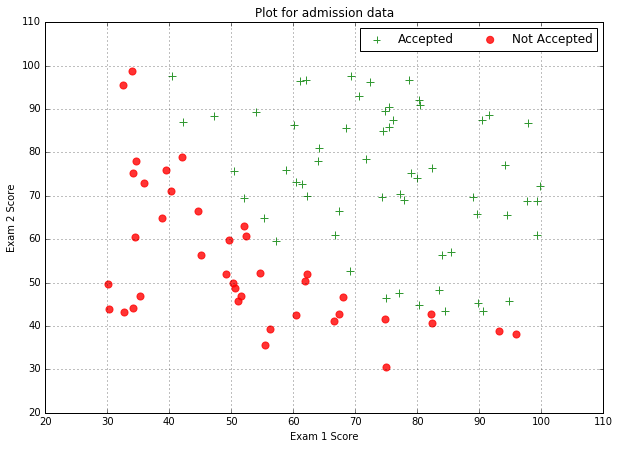

In [14]:
accept_x_exam = []
reject_x_exam = []
ind = 0
for row in train_y_exam:
    if row[0] == 0:
        reject_x_exam.append(train_x_exam[ind])
    else:
        accept_x_exam.append(train_x_exam[ind])
    ind += 1
    
accept_x_exam = np.array(accept_x_exam)
reject_x_exam = np.array(reject_x_exam)
draw_scatter_plot(accept_x_exam, reject_x_exam, 'Plot for admission data', 'Exam 1 Score', 'Exam 2 Score',1)

As you can see from the plot above that a straight line can be used a decision boundary for this dataset and hence we can make do with only two theta parameters

In [15]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [16]:
optimized_theta_exam = run_optimization(train_x_exam, train_y_exam, 0)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 23
         Function evaluations: 32
         Gradient evaluations: 32


In [17]:
accuracy_score_exam = get_accuracy(optimized_theta_exam, train_x_exam, train_y_exam)
print("Accuracy for admission data without regularization: ", accuracy_score_exam*100)

Accuracy for admission data without regularization:  89.0


In [18]:
x_points_exam = np.array([min(train_x_exam[:,[0]]),max(train_x_exam[:,[0]])])
y_points_exam = -1/optimized_theta_exam[2] * (x_points_exam * optimized_theta_exam[1] + optimized_theta_exam[0])

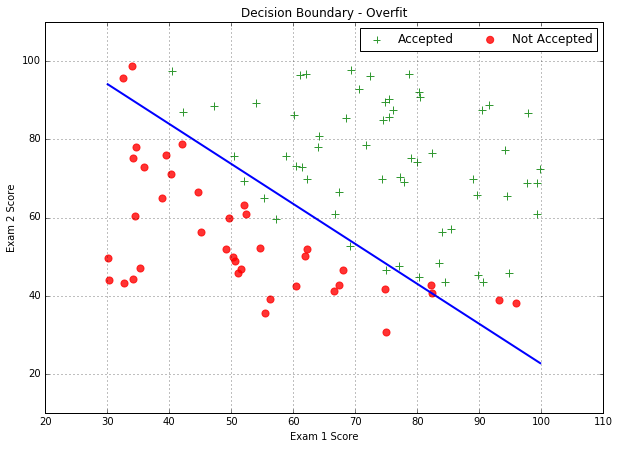

In [19]:
plot_decision_boundary(True,accept_x_exam, reject_x_exam, 'Decision Boundary - Overfit', 'Exam 1 Score', 'Exam 2 Score',2, x_points_exam, y_points_exam, None)

In [20]:
optimized_theta_exam = run_optimization(train_x_exam, train_y_exam, 1)

Optimization terminated successfully.
         Current function value: 0.203912
         Iterations: 26
         Function evaluations: 32
         Gradient evaluations: 32


In [21]:
accuracy_score_exam = get_accuracy(optimized_theta_exam, train_x_exam, train_y_exam)
print("Accuracy for admission data without regularization: ", accuracy_score_exam*100)

Accuracy for admission data without regularization:  89.0


In [22]:
x_points_exam = np.array([min(train_x_exam[:,[0]]),max(train_x_exam[:,[0]])])
y_points_exam = -1/optimized_theta_exam[2] * (x_points_exam * optimized_theta_exam[1] + optimized_theta_exam[0])

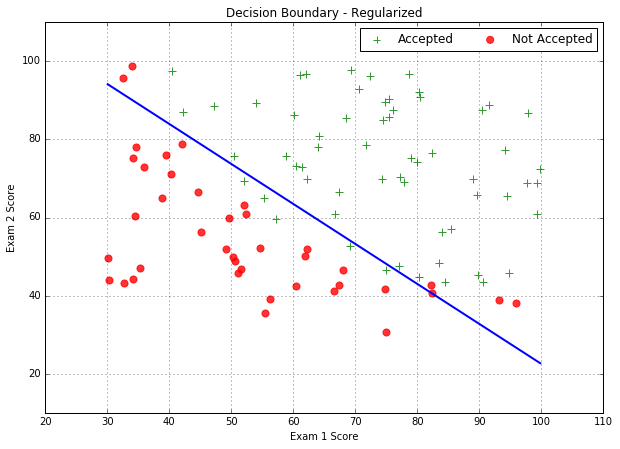

In [23]:
plot_decision_boundary(True,accept_x_exam, reject_x_exam, 'Decision Boundary - Regularized', 'Exam 1 Score', 'Exam 2 Score',2, x_points_exam, y_points_exam, None)

As you can see from the accuracy scores and plots above that regularization has no effect on this data.

# Question 1 for microchip data

In [24]:
filePath = 'data/ex2data2.txt'
x, x_n, y = read_data(filePath, False)
train_x = np.array(x)
train_X = np.array(x_n)
train_y = np.array(y).reshape((len(y),1))

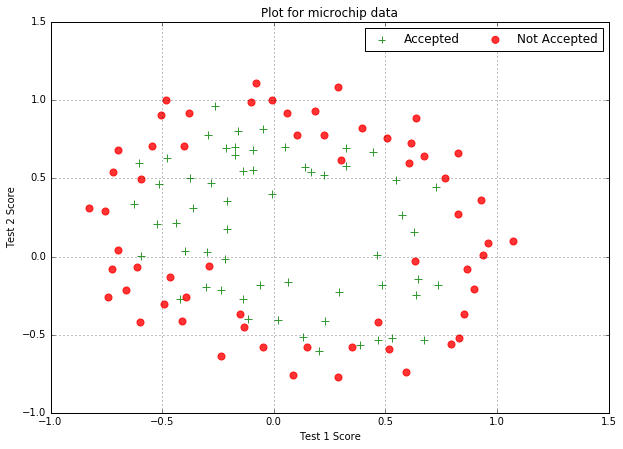

In [25]:
accept_x = []
reject_x = []
ind = 0
for row in train_y:
    if row[0] == 0:
        reject_x.append(train_x[ind])
    else:
        accept_x.append(train_x[ind])
    ind += 1
    
accept_x = np.array(accept_x)
reject_x = np.array(reject_x)

draw_scatter_plot(accept_x, reject_x, 'Plot for microchip data', 'Test 1 Score', 'Test 2 Score',3)

In [26]:
optimized_theta = run_optimization(train_X, train_y, 0)

Optimization terminated successfully.
         Current function value: 0.167950
         Iterations: 615
         Function evaluations: 619
         Gradient evaluations: 619


In [27]:
accuracy_score = get_accuracy(optimized_theta, train_X, train_y)
print("Accuracy for microchip data without regularization: ", accuracy_score*100)

Accuracy for microchip data without regularization:  91.52542372881356


In [28]:
u = np.linspace(-1, 1.5, num=50)
v = np.linspace(-1, 1.5, num=50)
z = np.zeros((u.shape[0],v.shape[0]))
i = 0
degree = 8
for row_u in u:
    j = 0
    for row_v in v:
        new_theta = optimized_theta.reshape(optimized_theta.shape[0],1)
        temp = []
        temp.append(float(1))
        for a in range(1,degree+1):
            for b in range(0,a+1):
                temp.append(float((u[i]**(a-b)) * (v[j]**b)))
        z[i][j] = np.dot(np.array(temp),new_theta)
        j+=1
    i+=1
    
z = np.transpose(z)

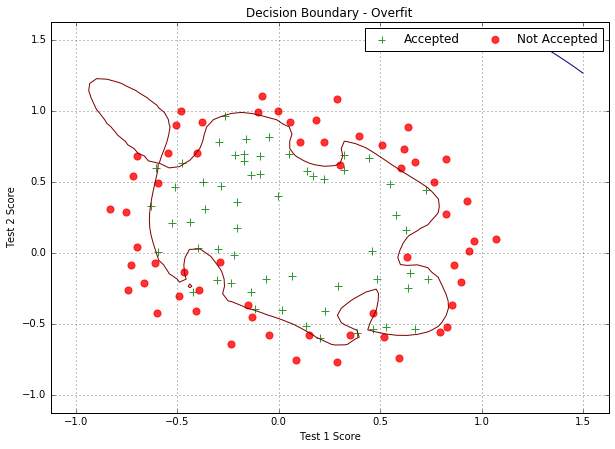

In [29]:
plot_decision_boundary(False,accept_x, reject_x, 'Decision Boundary - Overfit', 'Test 1 Score', 'Test 2 Score',4,u,v,z)

In [30]:
optimized_theta = run_optimization(train_X, train_y, 1)

Optimization terminated successfully.
         Current function value: 0.523112
         Iterations: 55
         Function evaluations: 56
         Gradient evaluations: 56


In [31]:
accuracy_score = get_accuracy(optimized_theta, train_X, train_y)
print("Accuracy for microchip data with regularization: ", accuracy_score*100)

Accuracy for microchip data with regularization:  83.05084745762711


In [32]:
u = np.linspace(-1, 1.5, num=50)
v = np.linspace(-1, 1.5, num=50)
z = np.zeros((u.shape[0],v.shape[0]))
i = 0
degree = 8
for row_u in u:
    j = 0
    for row_v in v:
        new_theta = optimized_theta.reshape(optimized_theta.shape[0],1)
        temp = []
        temp.append(float(1))
        for a in range(1,degree+1):
            for b in range(0,a+1):
                temp.append(float((u[i]**(a-b)) * (v[j]**b)))
        z[i][j] = np.dot(np.array(temp),new_theta)
        j+=1
    i+=1
    
z = np.transpose(z)

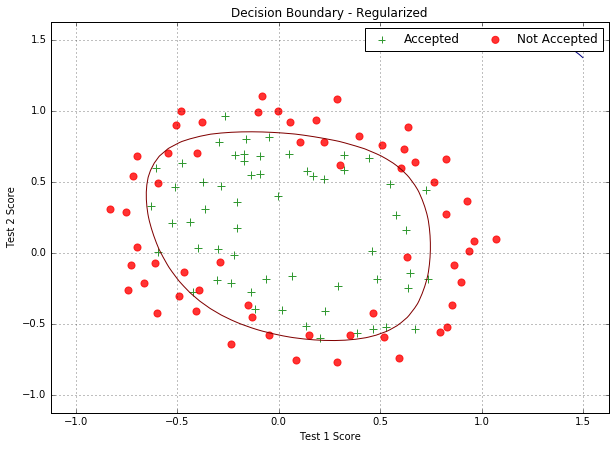

In [33]:
plot_decision_boundary(False,accept_x, reject_x, 'Decision Boundary - Regularized', 'Test 1 Score', 'Test 2 Score',4,u,v,z)

# Question 2

In [62]:
def batch_sgd(train_x, train_y, theta, learning_rate, batch_size, max_iters=400, tolerance=1e-5):
    train_x = np.concatenate((np.ones((train_x.shape[0], 1), dtype=float), train_x), axis=1)
    sample_size, dim_size = train_x.shape
    last_cost = np.inf
    
    theta_list = []
    cost_list = []
    
    for each_iter in range(max_iters):
        indices = np.random.choice(sample_size, batch_size, replace=False)
        x_batch, y_batch = train_x[indices], train_y[indices]
        
        theta -= learning_rate * gradient_function(theta, x_batch, y_batch, lambda_val=1.0)
        cost = cost_function(theta, train_x, train_y)
        
        theta_list.append(np.copy(theta))
        cost_list.append(float(cost))
        
         # cost < 100000000 is to ensure that
        if (abs(cost - last_cost) <= tolerance) and (cost < 100000000):
            break
        else:
            last_cost = cost
        
    return theta_list, cost_list

# Exam Data

In [63]:
theta = np.random.rand(train_x_exam.shape[1]+1)
train_y_exam = train_y_exam.reshape((train_x_exam.shape[0], 1))

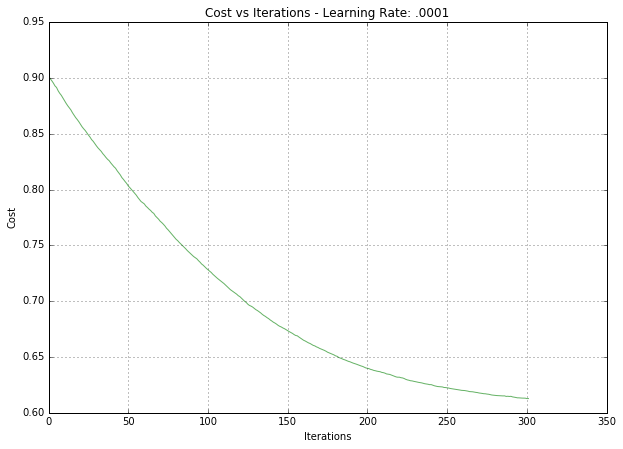

In [83]:
theta_list, cost_list = batch_sgd(train_x_exam, train_y_exam, theta, .0001, 80, 400, 1e-5)
plt.figure(5, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations - Learning Rate: .0001')
plt.plot(cost_list, color='green',alpha=0.6)
plt.grid(True)
plt.show()

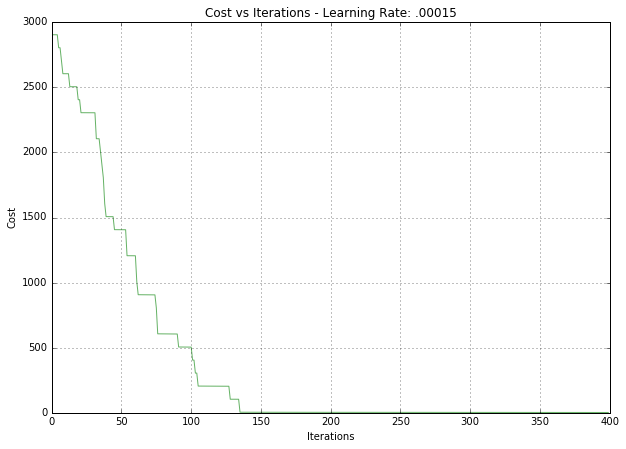

In [104]:
theta = np.random.rand(train_x_exam.shape[1]+1)
theta_list, cost_list = batch_sgd(train_x_exam, train_y_exam, theta, .00015, 80, 400, 1e-5)
plt.figure(6, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations - Learning Rate: .00015')
plt.plot(cost_list, color='green',alpha=0.6)
plt.grid(True)
plt.show()

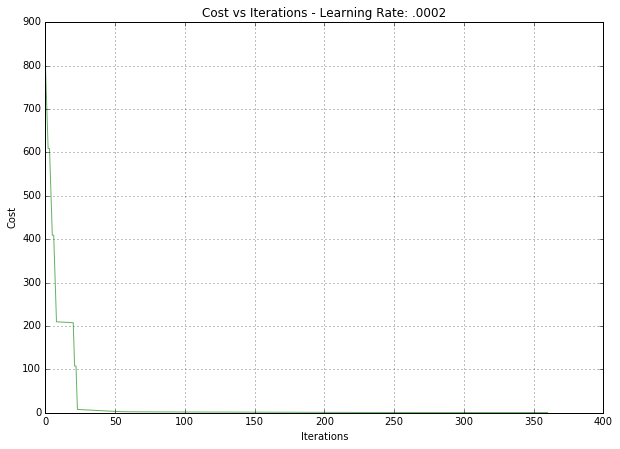

In [112]:
theta = np.random.rand(train_x_exam.shape[1]+1)
theta_list, cost_list = batch_sgd(train_x_exam, train_y_exam, theta, .0002, 80, 400, 1e-5)
plt.figure(7, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations - Learning Rate: .0002')
plt.plot(cost_list, color='green',alpha=0.6)
plt.grid(True)
plt.show()

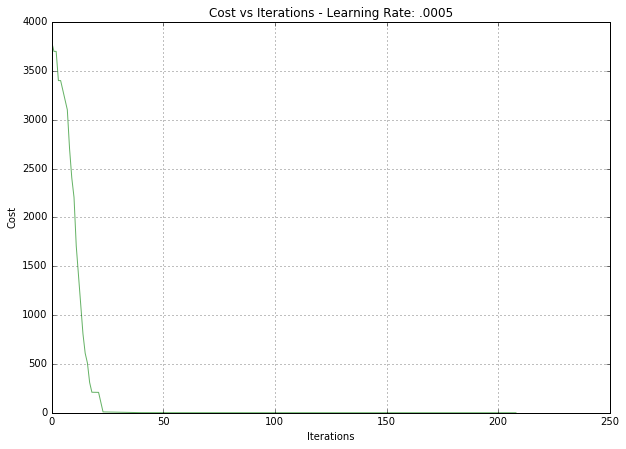

In [114]:
theta = np.random.rand(train_x_exam.shape[1]+1)
theta_list, cost_list = batch_sgd(train_x_exam, train_y_exam, theta, .0005, 80, 400, 1e-5)
plt.figure(8, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations - Learning Rate: .0005')
plt.plot(cost_list, color='green',alpha=0.6)
plt.grid(True)
plt.show()

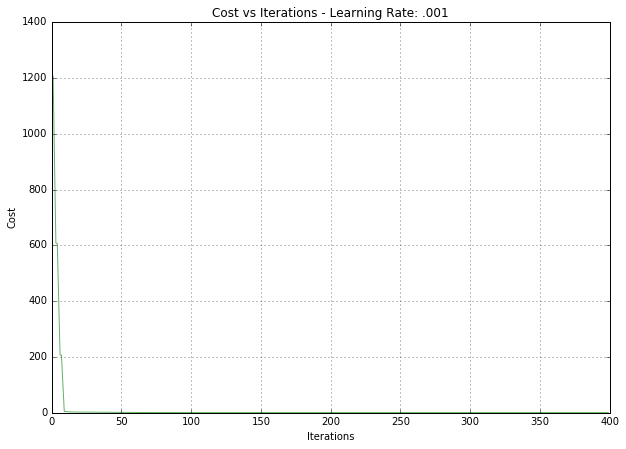

In [115]:
theta = np.random.rand(train_x_exam.shape[1]+1)
theta_list, cost_list = batch_sgd(train_x_exam, train_y_exam, theta, .001, 80, 400, 1e-5)
plt.figure(9, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations - Learning Rate: .001')
plt.plot(cost_list, color='green',alpha=0.6)
plt.grid(True)
plt.show()

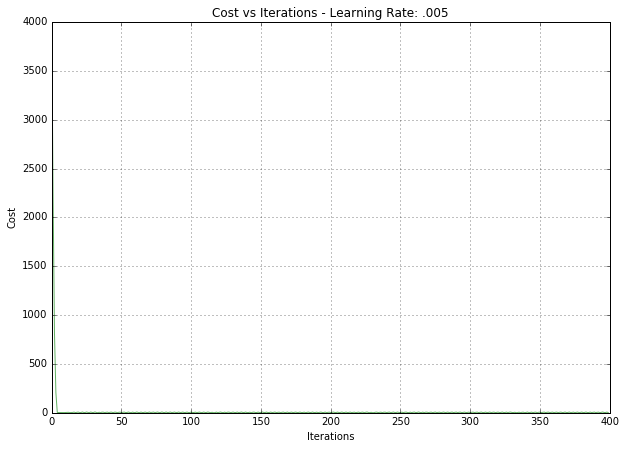

In [116]:
theta = np.random.rand(train_x_exam.shape[1]+1)
theta_list, cost_list = batch_sgd(train_x_exam, train_y_exam, theta, .005, 80, 400, 1e-5)
plt.figure(10, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations - Learning Rate: .005')
plt.plot(cost_list, color='green',alpha=0.6)
plt.grid(True)
plt.show()

# Microchip Data

In [74]:
theta = np.random.rand(train_x.shape[1]+1)
train_y = train_y.reshape((train_x.shape[0], 1))

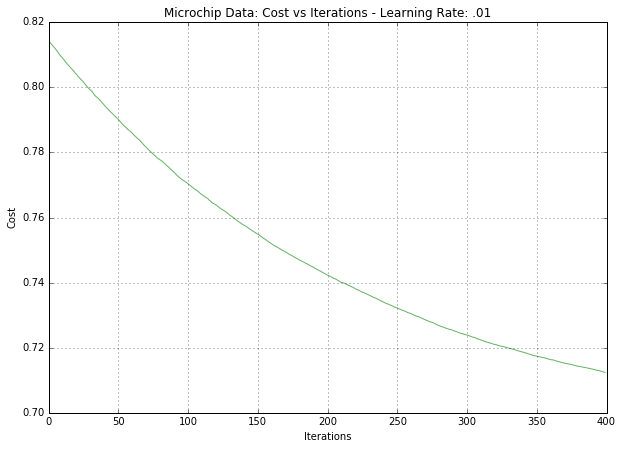

In [75]:
theta_list, cost_list = batch_sgd(train_x, train_y, theta, .01, 80, 400, 1e-5)
plt.figure(11, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Microchip Data: Cost vs Iterations - Learning Rate: .01')
plt.plot(cost_list, color='green',alpha=0.6)
plt.grid(True)
plt.show()

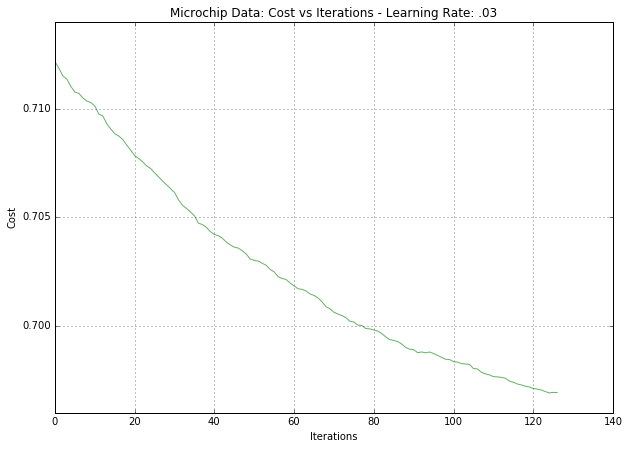

In [76]:
theta_list, cost_list = batch_sgd(train_x, train_y, theta, .03, 80, 400, 1e-5)
plt.figure(12, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Microchip Data: Cost vs Iterations - Learning Rate: .03')
plt.plot(cost_list, color='green',alpha=0.6)
plt.grid(True)
plt.show()

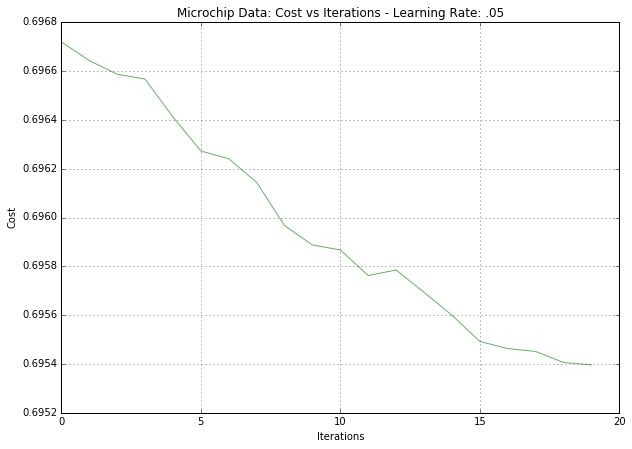

In [77]:
theta_list, cost_list = batch_sgd(train_x, train_y, theta, .05, 80, 400, 1e-5)
plt.figure(13, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Microchip Data: Cost vs Iterations - Learning Rate: .05')
plt.plot(cost_list, color='green',alpha=0.6)
plt.grid(True)
plt.show()

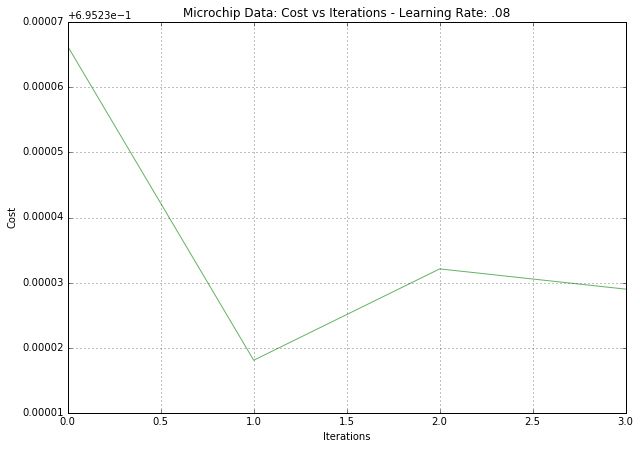

In [78]:
theta_list, cost_list = batch_sgd(train_x, train_y, theta, .08, 80, 400, 1e-5)
plt.figure(14, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Microchip Data: Cost vs Iterations - Learning Rate: .08')
plt.plot(cost_list, color='green',alpha=0.6)
plt.grid(True)
plt.show()

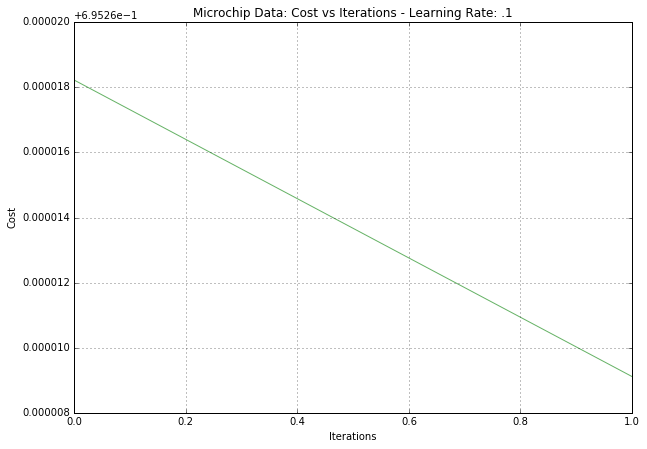

In [79]:
theta_list, cost_list = batch_sgd(train_x, train_y, theta, .1, 80, 400, 1e-5)
plt.figure(15, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Microchip Data: Cost vs Iterations - Learning Rate: .1')
plt.plot(cost_list, color='green',alpha=0.6)
plt.grid(True)
plt.show()

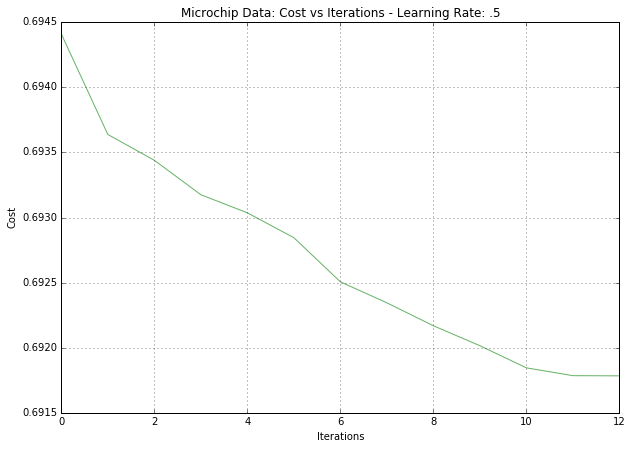

In [80]:
theta_list, cost_list = batch_sgd(train_x, train_y, theta, .5, 80, 400, 1e-5)
plt.figure(16, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Microchip Data: Cost vs Iterations - Learning Rate: .5')
plt.plot(cost_list, color='green',alpha=0.6)
plt.grid(True)
plt.show()

# Question 3

In [123]:
def parallel_batch_sgd(train_x, train_y, theta, learning_rate, batch_size, nthreads=1, max_iters=400, tolerance=1e-3):
    train_x = np.concatenate((np.ones((train_x.shape[0], 1), dtype=float), train_x), axis=1)
    sample_size, dim_size = train_x.shape
    
    theta_dict = {}
    cost_dict = {}
    
    # creating a array for each thread and storing it in a dict with a thread name
    for i in range(nthreads):
        key = 'thread_' + str(i)
        theta_dict[key] = []
        cost_dict[key] = []
    
    def threadwise_batch_sgd(thread_index, theta):
        last_cost = np.inf
        
        
        for each_iter in range(int(max_iters/nthreads)):
            indices = np.random.choice(sample_size, batch_size, replace=False)
            x_batch, y_batch = train_x[indices], train_y[indices]
            
            theta -= learning_rate * gradient_function(theta, x_batch, y_batch)
            
            cost = cost_function(theta, train_x, train_y)
            
            theta_dict[thread_index].append(np.copy(theta))
            cost_dict[thread_index].append(float(cost))
            
            # cost < 100000000 is to ensure that 
            if (abs(cost - last_cost) <= tolerance) and (cost < 100000000):
                break
            else:
                last_cost = cost
        
    thread_list = []
    
    for i in range(nthreads):
        thread_list.append(threading.Thread(target=threadwise_batch_sgd, args=('thread_' + str(i), theta)))
        
    for thread in thread_list: 
        thread.start()
        
    for thread in thread_list: 
        thread.join()
        
    return theta, theta_dict, cost_dict

# Exam Data

In [136]:
theta = np.random.rand(train_x_exam.shape[1]+1)
train_y_exam = train_y_exam.reshape((train_x_exam.shape[0], 1))

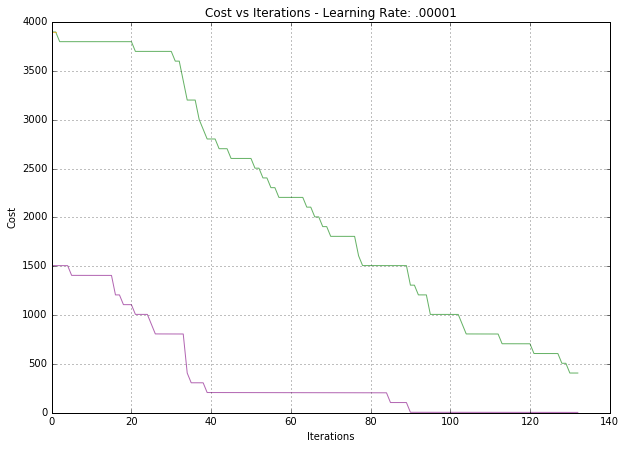

In [139]:
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x_exam, train_y_exam, theta, .00008, 80, 3, 400, 1e-5)
plt.figure(17, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations - Learning Rate: .00001')
plt.plot(cost_dict['thread_0'], color='green',alpha=0.6)
plt.plot(cost_dict['thread_1'], color='orange',alpha=0.6) 
plt.plot(cost_dict['thread_2'], color='purple',alpha=0.6)
plt.grid(True)
plt.show()

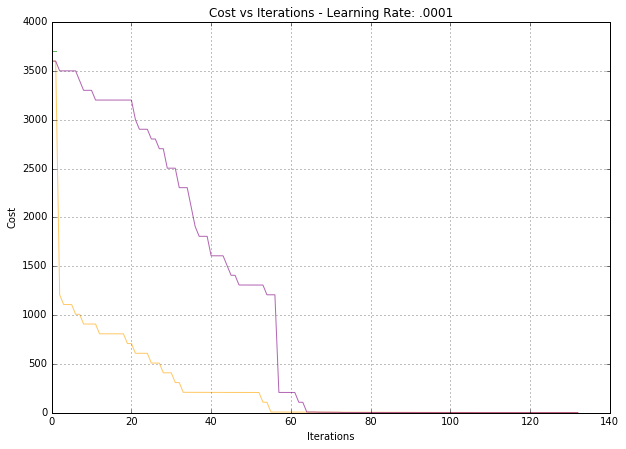

In [140]:
theta = np.random.rand(train_x_exam.shape[1]+1)
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x_exam, train_y_exam, theta, .0001, 80, 3, 400, 1e-5)
plt.figure(18, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations - Learning Rate: .0001')
plt.plot(cost_dict['thread_0'], color='green',alpha=0.6)
plt.plot(cost_dict['thread_1'], color='orange',alpha=0.6) 
plt.plot(cost_dict['thread_2'], color='purple',alpha=0.6)
plt.grid(True)
plt.show()

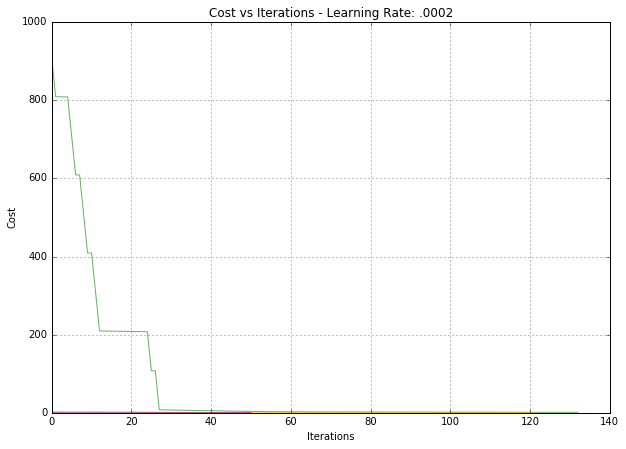

In [141]:
theta = np.random.rand(train_x_exam.shape[1]+1)
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x_exam, train_y_exam, theta, .0002, 80, 3, 400, 1e-5)
plt.figure(19, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations - Learning Rate: .0002')
plt.plot(cost_dict['thread_0'], color='green',alpha=0.6)
plt.plot(cost_dict['thread_1'], color='orange',alpha=0.6) 
plt.plot(cost_dict['thread_2'], color='purple',alpha=0.6)
plt.grid(True)
plt.show()

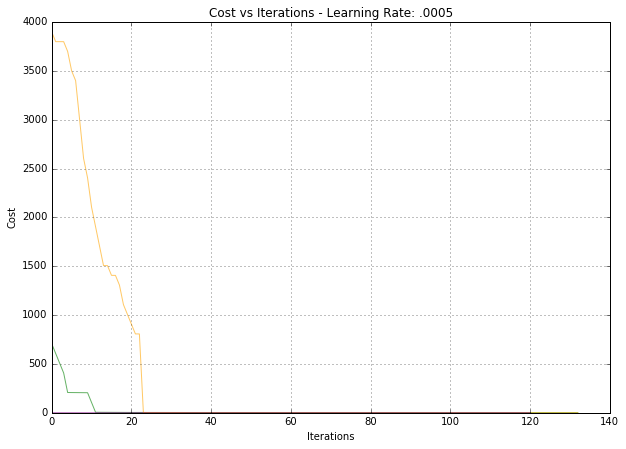

In [153]:
theta = np.random.rand(train_x_exam.shape[1]+1)
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x_exam, train_y_exam, theta, .0005, 80, 3, 400, 1e-5)
plt.figure(20, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations - Learning Rate: .0005')
plt.plot(cost_dict['thread_0'], color='green',alpha=0.6)
plt.plot(cost_dict['thread_1'], color='orange',alpha=0.6) 
plt.plot(cost_dict['thread_2'], color='purple',alpha=0.6)
plt.grid(True)
plt.show()

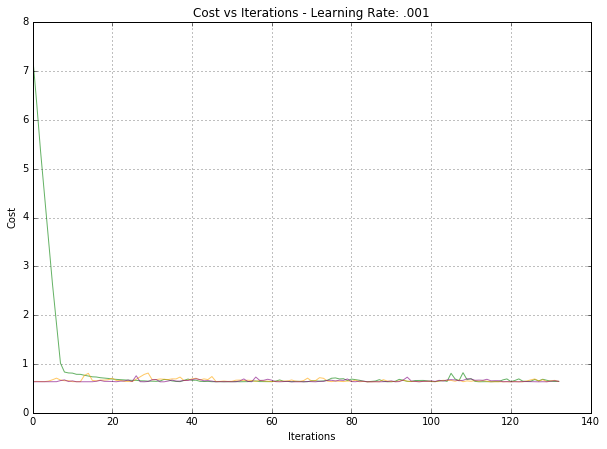

In [154]:
theta = np.random.rand(train_x_exam.shape[1]+1)
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x_exam, train_y_exam, theta, .001, 80, 3, 400, 1e-5)
plt.figure(21, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations - Learning Rate: .001')
plt.plot(cost_dict['thread_0'], color='green',alpha=0.6)
plt.plot(cost_dict['thread_1'], color='orange',alpha=0.6) 
plt.plot(cost_dict['thread_2'], color='purple',alpha=0.6)
plt.grid(True)
plt.show()

# Microchip Data

In [155]:
theta = np.random.rand(train_x.shape[1]+1)
train_y = train_y.reshape((train_x.shape[0], 1))

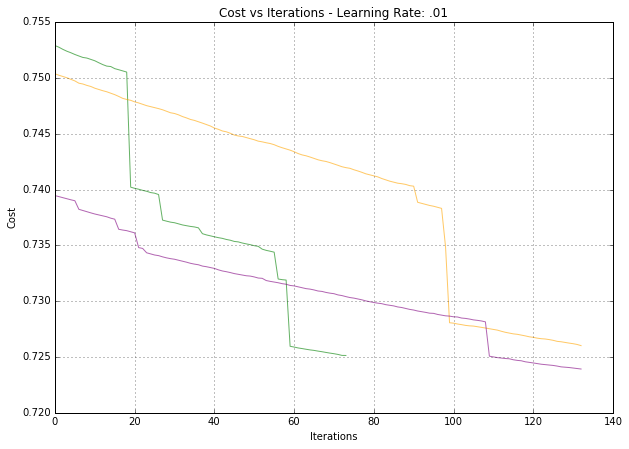

In [157]:
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x, train_y, theta, .01, 80, 3, 400, 1e-5)
plt.figure(22, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Microchip Data: Cost vs Iterations - Learning Rate: .01')
plt.plot(cost_dict['thread_0'], color='green',alpha=0.6)
plt.plot(cost_dict['thread_1'], color='orange',alpha=0.6) 
plt.plot(cost_dict['thread_2'], color='purple',alpha=0.6)
plt.grid(True)
plt.show()

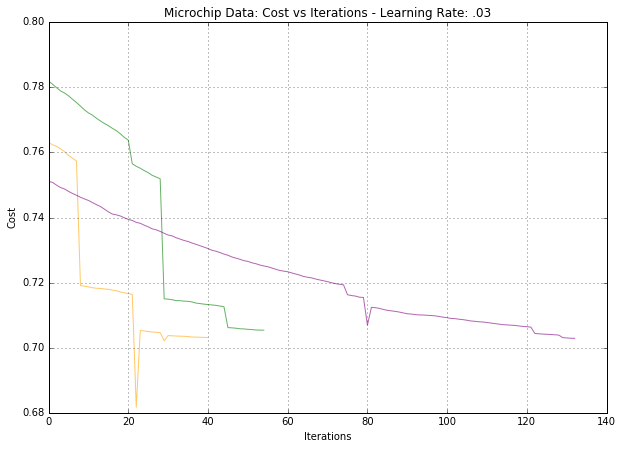

In [158]:
theta = np.random.rand(train_x.shape[1]+1)
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x, train_y, theta, .03, 80, 3, 400, 1e-5)
plt.figure(23, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Microchip Data: Cost vs Iterations - Learning Rate: .03')
plt.plot(cost_dict['thread_0'], color='green',alpha=0.6)
plt.plot(cost_dict['thread_1'], color='orange',alpha=0.6) 
plt.plot(cost_dict['thread_2'], color='purple',alpha=0.6)
plt.grid(True)
plt.show()

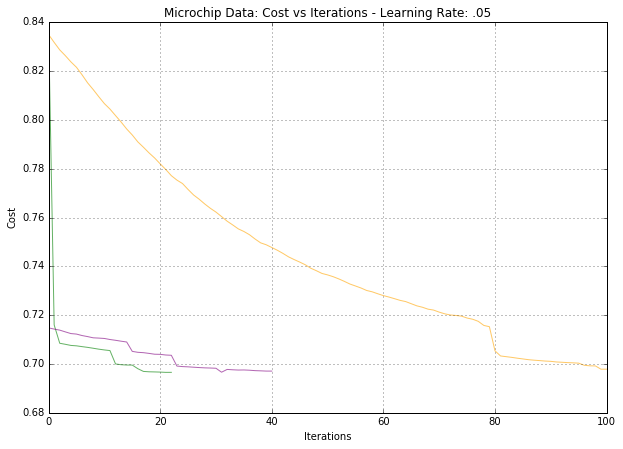

In [160]:
theta = np.random.rand(train_x.shape[1]+1)
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x, train_y, theta, .05, 80, 3, 400, 1e-5)
plt.figure(24, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Microchip Data: Cost vs Iterations - Learning Rate: .05')
plt.plot(cost_dict['thread_0'], color='green',alpha=0.6)
plt.plot(cost_dict['thread_1'], color='orange',alpha=0.6) 
plt.plot(cost_dict['thread_2'], color='purple',alpha=0.6)
plt.grid(True)
plt.show()

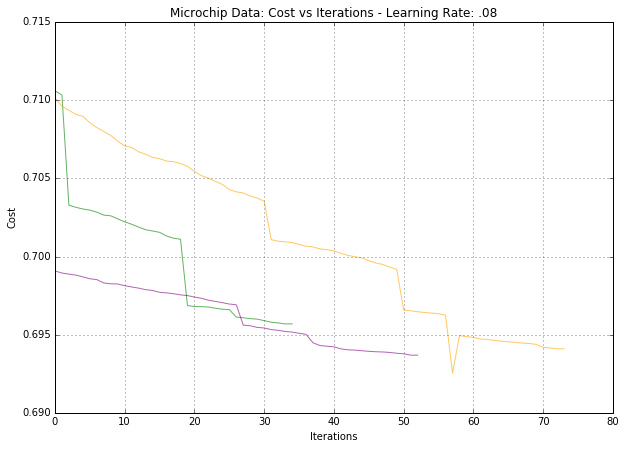

In [163]:
theta = np.random.rand(train_x.shape[1]+1)
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x, train_y, theta, .08, 80, 3, 400, 1e-5)
plt.figure(25, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Microchip Data: Cost vs Iterations - Learning Rate: .08')
plt.plot(cost_dict['thread_0'], color='green',alpha=0.6)
plt.plot(cost_dict['thread_1'], color='orange',alpha=0.6) 
plt.plot(cost_dict['thread_2'], color='purple',alpha=0.6)
plt.grid(True)
plt.show()

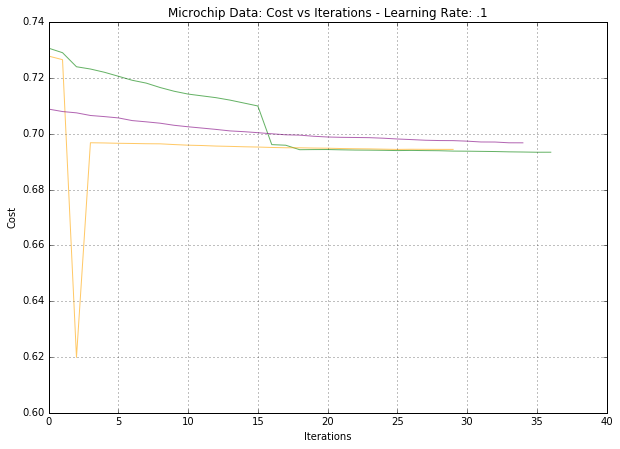

In [165]:
theta = np.random.rand(train_x.shape[1]+1)
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x, train_y, theta, .1, 80, 3, 400, 1e-5)
plt.figure(26, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Microchip Data: Cost vs Iterations - Learning Rate: .1')
plt.plot(cost_dict['thread_0'], color='green',alpha=0.6)
plt.plot(cost_dict['thread_1'], color='orange',alpha=0.6) 
plt.plot(cost_dict['thread_2'], color='purple',alpha=0.6)
plt.grid(True)
plt.show()

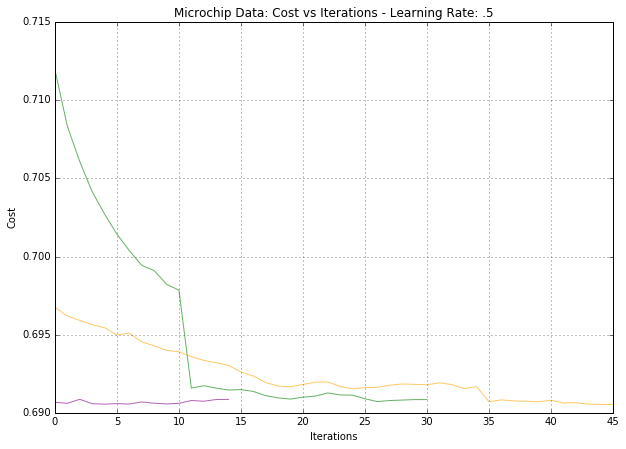

In [167]:
theta = np.random.rand(train_x.shape[1]+1)
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x, train_y, theta, .5, 80, 3, 400, 1e-5)
plt.figure(27, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Microchip Data: Cost vs Iterations - Learning Rate: .5')
plt.plot(cost_dict['thread_0'], color='green',alpha=0.6)
plt.plot(cost_dict['thread_1'], color='orange',alpha=0.6) 
plt.plot(cost_dict['thread_2'], color='purple',alpha=0.6)
plt.grid(True)
plt.show()

As you can see from the plots above we start getting faster convergence for threads as we start increasing the learning rate.

# Exam Data - Relative profiling of speed

Parallel Batch SGD - Timings

In [199]:
theta = np.random.rand(train_x_exam.shape[1]+1)
start_time = time.time()
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x_exam, train_y_exam, theta, .001, 80, 1, 400, 1e-5)
print("Time taken by 1 thread for Exam Data: ",(time.time() - start_time))

Time taken by 1 thread for Exam Data:  0.13312506675720215


In [200]:
theta = np.random.rand(train_x_exam.shape[1]+1)
start_time = time.time()
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x_exam, train_y_exam, theta, .001, 80, 2, 400, 1e-5)
print("Time taken by 2 threads for Exam Data: ",(time.time() - start_time))

Time taken by 2 threads for Exam Data:  0.10748600959777832


In [211]:
theta = np.random.rand(train_x_exam.shape[1]+1)
start_time = time.time()
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x_exam, train_y_exam, theta, .001, 80, 3, 400, 1e-5)
print("Time taken by 3 threads for Exam Data: ",(time.time() - start_time))

Time taken by 3 threads for Exam Data:  0.03811216354370117


In [213]:
theta = np.random.rand(train_x_exam.shape[1]+1)
start_time = time.time()
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x_exam, train_y_exam, theta, .001, 80, 4, 400, 1e-5)
print("Time taken by 4 threads for Exam Data: ",(time.time() - start_time))

Time taken by 4 threads for Exam Data:  0.004410982131958008


Normal SGD - Timings

In [215]:
start_time = time.time()
theta = np.random.rand(train_x_exam.shape[1]+1)
theta_list, cost_list = batch_sgd(train_x_exam, train_y_exam, theta, .001, 80, 400, 1e-5)
print("Time taken Normal Batch SGD for Exam Data: ",(time.time() - start_time))

Time taken Normal Batch SGD for Exam Data:  0.13141322135925293


# Microchip Data - Relative profiling of speed

Parallel Batch SGD Timings

In [251]:
theta = np.random.rand(train_x.shape[1]+1)
start_time = time.time()
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x, train_y, theta, .1, 80, 1, 400, 1e-5)
print("Time taken by 1 thread for Microchip Data: ",(time.time() - start_time))

Time taken by 1 thread for Microchip Data:  0.06100606918334961


In [231]:
theta = np.random.rand(train_x.shape[1]+1)
start_time = time.time()
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x, train_y, theta, .1, 80, 2, 400, 1e-5)
print("Time taken by 2 threads for Microchip Data: ",(time.time() - start_time))

Time taken by 2 threads for Microchip Data:  0.057643890380859375


In [255]:
theta = np.random.rand(train_x.shape[1]+1)
start_time = time.time()
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x, train_y, theta, .1, 80, 3, 400, 1e-5)
print("Time taken by 3 threads for Microchip Data: ",(time.time() - start_time))

Time taken by 3 threads for Microchip Data:  0.036186933517456055


In [276]:
theta = np.random.rand(train_x.shape[1]+1)
start_time = time.time()
theta, theta_dict, cost_dict = parallel_batch_sgd(train_x, train_y, theta, .1, 80, 4, 400, 1e-5)
print("Time taken by 4 threads for Microchip Data: ",(time.time() - start_time))

Time taken by 4 threads for Microchip Data:  0.0263813213056029


Normal SGD - Timings

In [281]:
start_time = time.time()
theta = np.random.rand(train_x.shape[1]+1)
theta_list, cost_list = batch_sgd(train_x, train_y, theta, .1, 80, 400, 1e-5)
print("Time taken Normal Batch SGD for Microchip Data: ",(time.time() - start_time))

Time taken Normal Batch SGD for Microchip Data:  0.06800619257134263
